In [43]:
import ee
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import agrigee_lite as agl

In [21]:
ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com", project="ee-mateuspsilva")

In [61]:
sat = agl.sat.Sentinel2()

In [40]:
gdf_california = gpd.read_parquet("california_with_crop_names.parquet")
gdf_years = np.load("california_test.npz")["year"]
gdf_varda_id = np.load("california_test.npz", allow_pickle=True)["varda_id"]
california_filter_df = pd.DataFrame({"varda_id": gdf_varda_id, "year": gdf_years}).drop_duplicates()
california_filtered_gdf = gdf_california.merge(california_filter_df, on=["varda_id", "year"])
california_filtered_gdf = california_filtered_gdf[california_filtered_gdf.start_date >= sat.startDate].reset_index(drop=True)
california_sampled_gdf = california_filtered_gdf.sample(n=1000, random_state=42).reset_index(drop=True)

In [59]:
gdf_texas = gpd.read_parquet("texas_with_crop_names.parquet")
gdf_years = np.load("texas_test.npz")["year"]
gdf_varda_id = np.load("texas_test.npz", allow_pickle=True)["varda_id"]
texas_filter_df = pd.DataFrame({"varda_id": gdf_varda_id, "year": gdf_years}).drop_duplicates()
texas_filtered_gdf = gdf_texas.merge(texas_filter_df, on=["varda_id", "year"])
texas_filtered_gdf = texas_filtered_gdf[texas_filtered_gdf.start_date >= sat.startDate].reset_index(drop=True)
texas_sampled_gdf = texas_filtered_gdf.sample(n=1000, random_state=42).reset_index(drop=True)

In [63]:
data = agl.get.multiple_sits(california_sampled_gdf, sat, reducers=["std"], force_redownload=True)

Simplifying clusters: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


In [65]:
data.columns.tolist()

['indexnum',
 'timestamp',
 'blue',
 'green',
 'red',
 're1',
 're2',
 're3',
 'nir',
 're4',
 'swir1',
 'swir2']

Simplifying clusters: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


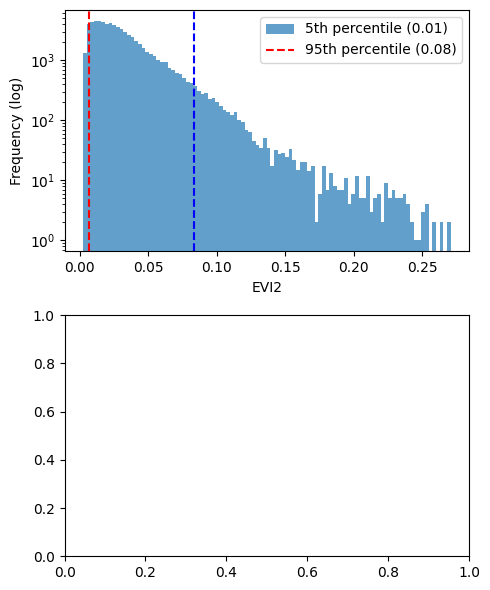

In [58]:
fig, ax = plt.subplots(2, figsize=(5, 6))

data = agl.get.multiple_sits(california_sampled_gdf, sat, reducers=["std"]).evi2
data = data[data>0].reset_index(drop=True)
data.plot.hist(bins=100, log=True, ax=ax[0], alpha=0.7)

p5 = data.quantile(0.05)
p95 = data.quantile(0.95)

ax[0].axvline(p5, color='red', linestyle='--', label='5th percentile')
ax[0].axvline(p95, color='blue', linestyle='--', label='95th percentile')

ax[0].legend([
    f'5th percentile ({p5:.2f})',
    f'95th percentile ({p95:.2f})'
])
ax[0].set_xlabel("EVI2")
ax[0].set_ylabel("Frequency (log)")

plt.tight_layout()
plt.show()

Simplifying clusters: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


california - blue - 5: 0.00 - 95: 0.02
california - green - 5: 0.00 - 95: 0.02
california - red - 5: 0.00 - 95: 0.03
california - re1 - 5: 0.00 - 95: 0.03
california - re2 - 5: 0.00 - 95: 0.04
california - re3 - 5: 0.01 - 95: 0.05
california - nir - 5: 0.01 - 95: 0.05
california - re4 - 5: 0.01 - 95: 0.05
california - swir1 - 5: 0.01 - 95: 0.04
california - swir2 - 5: 0.00 - 95: 0.04


Simplifying clusters: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


texas - blue - 5: 0.00 - 95: 0.02
texas - green - 5: 0.00 - 95: 0.02
texas - red - 5: 0.00 - 95: 0.03
texas - re1 - 5: 0.01 - 95: 0.04
texas - re2 - 5: 0.01 - 95: 0.04
texas - re3 - 5: 0.01 - 95: 0.05
texas - nir - 5: 0.01 - 95: 0.05
texas - re4 - 5: 0.01 - 95: 0.05
texas - swir1 - 5: 0.01 - 95: 0.06
texas - swir2 - 5: 0.01 - 95: 0.05


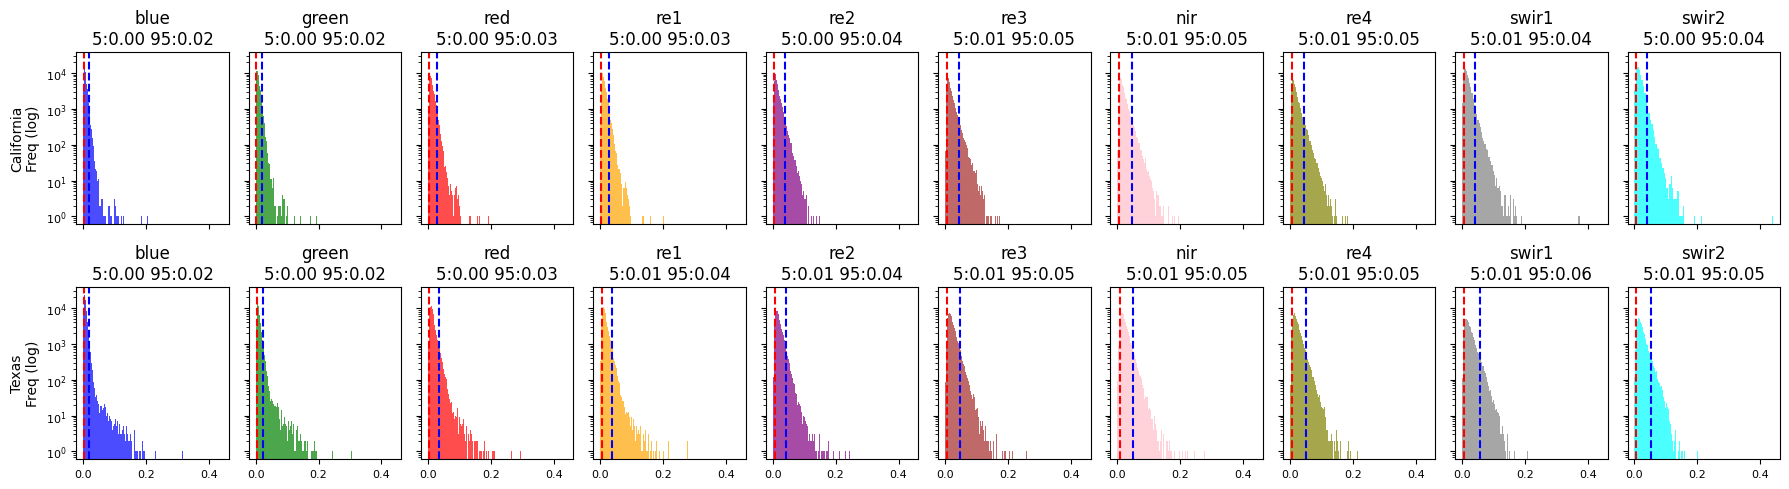

In [75]:
bands = ['blue', 'green', 'red', 're1', 're2', 're3', 'nir', 're4', 'swir1', 'swir2']
colors = {
    'blue': 'blue',
    'green': 'green',
    'red': 'red',
    're1': 'orange',
    're2': 'purple',
    're3': 'brown',
    'nir': 'pink',
    're4': 'olive',
    'swir1': 'gray',
    'swir2': 'cyan'
}

fig, ax = plt.subplots(2, 10, figsize=(18, 5), sharex=True, sharey=True)

# --- CALIFORNIA ---
cal_data = agl.get.multiple_sits(california_sampled_gdf, sat, reducers=["std"])

for i, band in enumerate(bands):
    data = cal_data[band]
    data = data[data > 0].reset_index(drop=True)

    data.plot.hist(bins=100, log=True, ax=ax[0, i], color=colors[band], alpha=0.7)

    p5 = data.quantile(0.05)
    p95 = data.quantile(0.95)

    ax[0, i].axvline(p5, color='red', linestyle='--')
    ax[0, i].axvline(p95, color='blue', linestyle='--')
    ax[0, i].set_title(f"{band}\n5:{p5:.2f} 95:{p95:.2f}")
    ax[0, i].tick_params(labelsize=8)

    print(f"california - {band} - 5: {p5:.2f} - 95: {p95:.2f}")

# --- TEXAS ---
tex_data = agl.get.multiple_sits(texas_sampled_gdf, sat, reducers=["std"])

for i, band in enumerate(bands):
    data = tex_data[band]
    data = data[data > 0].reset_index(drop=True)

    data.plot.hist(bins=100, log=True, ax=ax[1, i], color=colors[band], alpha=0.7)

    p5 = data.quantile(0.05)
    p95 = data.quantile(0.95)

    ax[1, i].axvline(p5, color='red', linestyle='--')
    ax[1, i].axvline(p95, color='blue', linestyle='--')
    ax[1, i].set_title(f"{band}\n5:{p5:.2f} 95:{p95:.2f}")
    ax[1, i].tick_params(labelsize=8)

    print(f"texas - {band} - 5: {p5:.2f} - 95: {p95:.2f}")

# Eixos
ax[0, 0].set_ylabel("California\nFreq (log)")
ax[1, 0].set_ylabel("Texas\nFreq (log)")

plt.tight_layout()
plt.savefig("cm_hugo/histograms_std.pdf", bbox_inches='tight')

In [57]:
data

0        0.027695
1        0.044586
2        0.041534
3        0.024750
4        0.022919
           ...   
69950    0.006840
69951    0.006413
69952    0.009598
69953    0.010719
69954    0.011528
Name: evi2, Length: 69955, dtype: float16

In [36]:
agl.get.multiple_sits(sampled_gdf, sat, reducers=["std"]).evi2.quantile(0.95)

Simplifying clusters: 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


np.float64(0.08351440429687518)

In [38]:
sampled_gdf.ha.min()

np.float64(6.254917667453374)